<a href="https://colab.research.google.com/github/jimitogni/dissertacao/blob/master/transfer_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

import os
from numpy.random import seed
import tensorflow as tf
import torch
import pandas as pd
import numpy as np
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import random
import matplotlib.image as mpimg 
from PIL import Image

tf.random.set_seed(100)

Metodo para buscar diretórios

In [0]:
def search_dir(type="normal", num=6):
  #funcao que ajuda scanear um diretorio
  counter = 0

  for file in os.listdir('dataset/test/covid/'):
    if counter == num:
      break

    if file.endswith(".jpeg"):
      print(file)

    counter += 1


Função que auxilia a plotar as imagens utilizando a biblioteca mpimg


In [0]:
def plot_images(type="normal", num=6):
  #auxilia ao plotar imagens
  counter = 0

  fig = plt.figure(figsize=(10,8))
  print("antes do for")
  print("list_dir = {}".format(os.listdir(train_dir)))
  print("train_dir + file = {}".format(os.listdir(train_dir + file)))

  for file in os.listdir(train_dir):
    if file.endswith(".jpeg"):
      print("passou no if 1")
      if counter == num:
        print("parrou no if 2 - nao achou nada")
        break

      img = mpimg.imread(train_dir + file)
      plt.subplot(231+counter)
      plt.title(file.split('.')[0])
      imgplot = plt.imshow(img)

      counter += 1
      print("chegou até o final do for")


Metodo para plotar os gráficos das curvas de aprendizado

In [0]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: #set up subplot in first call
    plt.subplots(figsize=(10,10))
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model' + title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

Usando a API do kaggle para baixar uma base de dados com imagens de Raios-X que contem **imagens de pulmões normais e com pneumonia**

In [0]:
os.environ['KAGLE_USERNAME']= "jimitogni"
os.environ['KAGLE_KEY']= "6ba3f466a063e70addd26514bb2cf41d"

In [6]:
%%shell
pip install kaggle
export KAGGLE_USERNAME=jimitogni
export KAGGLE_KEY=6ba3f466a063e70addd26514bb2cf41d

kaggle datasets download paultimothymooney/chest-xray-pneumonia
unzip -q chest-xray-pneumonia.zip

 99% 2.27G/2.29G [00:48<00:00, 30.3MB/s]
100% 2.29G/2.29G [00:48<00:00, 51.2MB/s]


Agora pegamos a base de dados que contem apenas Raios-X com imagens de pessoas contaminadas com COVID-19

In [7]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 1575 (delta 28), reused 41 (delta 18), pack-reused 1511
Receiving objects: 100% (1575/1575), 216.44 MiB | 31.10 MiB/s, done.
Resolving deltas: 100% (752/752), done.
Checking out files: 100% (341/341), done.


Agrupando as duas bases de dados

In [8]:
# Load Kaggle Pneumonia Dataset
def get_dataset(path, label):
  return [[path+x, label] for x in os.listdir(path) if not x.startswith('.')]

root = 'chest_xray/chest_xray/train/'
normal_xray = get_dataset(root+'NORMAL/', 'normal')
pneumonia_xray = get_dataset(root+'PNEUMONIA/', 'pneumonia')
print(len(normal_xray), normal_xray[0:5])
print(len(pneumonia_xray), pneumonia_xray[0:5])

# Load Covid-19 Dataset
metadata_path='covid-chestxray-dataset/metadata.csv'
srcpath = 'covid-chestxray-dataset/images/'
df=pd.read_csv(metadata_path)
covid_patients=df['finding']=='COVID-19'
PA=df['view']=='PA'
PA_covid=df[covid_patients & PA]
covid_xray = [[srcpath + files, 'covid'] for files in PA_covid['filename']]
print(len(covid_xray), covid_xray[0:5])

random.shuffle(normal_xray)
random.shuffle(pneumonia_xray)
random.shuffle(covid_xray)

# gerando dados balanceados e randomizados
min_size = min(len(normal_xray), len(pneumonia_xray), len(covid_xray))-1
dataset = normal_xray[0:min_size] + covid_xray[0:min_size] + pneumonia_xray[0:min_size]
random.shuffle(dataset)

print(len(dataset), dataset[0:5])

# carregando os dados para um df pandas
df = pd.DataFrame(dataset, columns=['X', 'y']).sample(frac=1)
print(df)

X = df['X']
y = df['y']

classes= y.unique()
print(classes)

# Split em train, valid, e test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print()
print()
print("Total de imagens {}, Dados para: treino={}, Validação={} e Teste={} ".format(len(df), len(X_train), len(X_val), len(X_test)))

!rm -rf dataset/ #remove a pasta se ela ja existir

#cria uma nova pasta com as duas bases de dados agrupadas
for dtype, dinputs, doutputs in [['train', X_train, y_train], ['val', X_val, y_val], ['test', X_test, y_test]]:
  for _X, _y in zip(dinputs, doutputs):
    path = 'dataset/'+dtype+'/'+_y
    os.makedirs(path, exist_ok=True)
    # print(_X, path)
    shutil.copy(_X, path)

!tar -czf dataset.tar.gz dataset/ #guarda toda a base obtida em um arquivo zip

1341 [['chest_xray/chest_xray/train/NORMAL/IM-0355-0001.jpeg', 'normal'], ['chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0809-0001.jpeg', 'normal'], ['chest_xray/chest_xray/train/NORMAL/IM-0312-0001.jpeg', 'normal'], ['chest_xray/chest_xray/train/NORMAL/IM-0593-0001.jpeg', 'normal'], ['chest_xray/chest_xray/train/NORMAL/IM-0490-0001.jpeg', 'normal']]
3875 [['chest_xray/chest_xray/train/PNEUMONIA/person151_virus_301.jpeg', 'pneumonia'], ['chest_xray/chest_xray/train/PNEUMONIA/person489_virus_994.jpeg', 'pneumonia'], ['chest_xray/chest_xray/train/PNEUMONIA/person441_bacteria_1915.jpeg', 'pneumonia'], ['chest_xray/chest_xray/train/PNEUMONIA/person440_bacteria_1897.jpeg', 'pneumonia'], ['chest_xray/chest_xray/train/PNEUMONIA/person1339_bacteria_3399.jpeg', 'pneumonia']]
133 [['covid-chestxray-dataset/images/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', 'covid'], ['covid-chestxray-dataset/images/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jp

In [0]:
#explore data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

distribuição da divisão das bases: treino - validação - teste, respectivamente: 252 64 80
classes ['covid', 'normal', 'pneumonia']


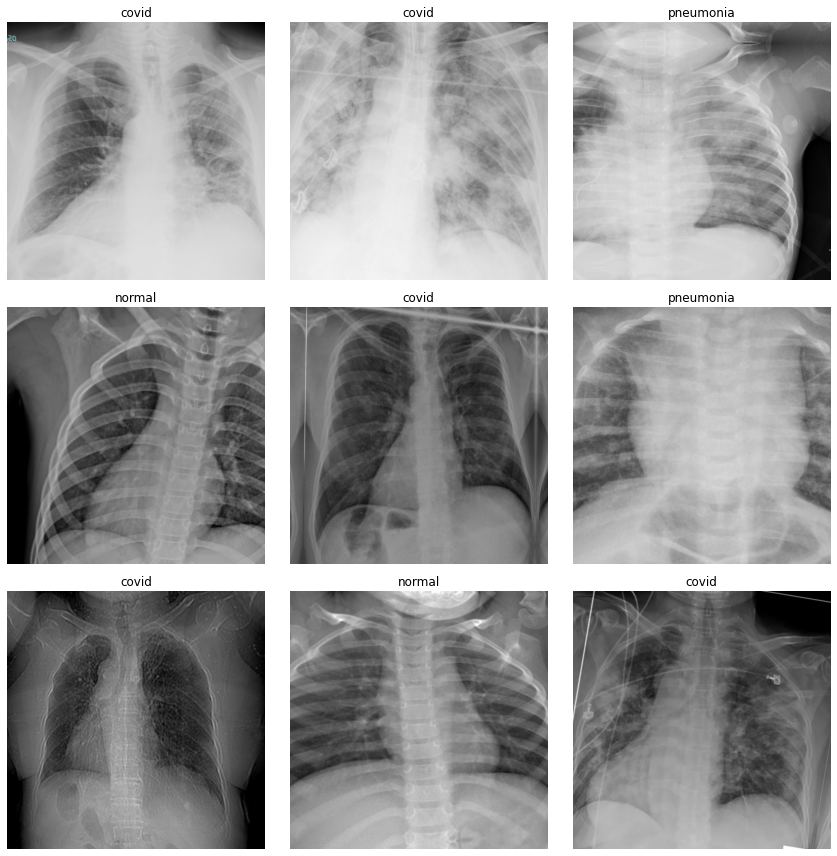

In [10]:
#amostras de imagens com rotulos
def stage(data):
  print("distribuição da divisão das bases: treino - validação - teste, respectivamente:", len(data.train_ds),len(data.valid_ds),len(data.test_ds.x))
  print("classes", data.classes)
  data.show_batch(20)
  return None

tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=15.0, max_lighting=0.1, max_zoom=1.05)#, max_warp=0.

data = ImageDataBunch.from_folder('dataset', train="train", valid='val',test='test', ds_tfms=get_transforms(tfms), bs=9, size=512, num_workers=4).normalize()
stage(data)

In [0]:
#diretorios
train_dir = "dataset/train/"
val_dir = "dataset/val/"
test_dir = "dataset/test/"

In [12]:
search_dir(type="pneumonia", num=10)
search_dir(type="normal", num=10)
search_dir(type="covid", num=10)


ryct.2020200034.fig5-day7.jpeg
2966893D-5DDF-4B68-9E2B-4979D5956C8E.jpeg
53EC07C9-5CC6-4BE4-9B6F-D7B0D72AAA7E.jpeg
ryct.2020200034.fig5-day7.jpeg
2966893D-5DDF-4B68-9E2B-4979D5956C8E.jpeg
53EC07C9-5CC6-4BE4-9B6F-D7B0D72AAA7E.jpeg
ryct.2020200034.fig5-day7.jpeg
2966893D-5DDF-4B68-9E2B-4979D5956C8E.jpeg
53EC07C9-5CC6-4BE4-9B6F-D7B0D72AAA7E.jpeg


Plotando apelas imagens com covid

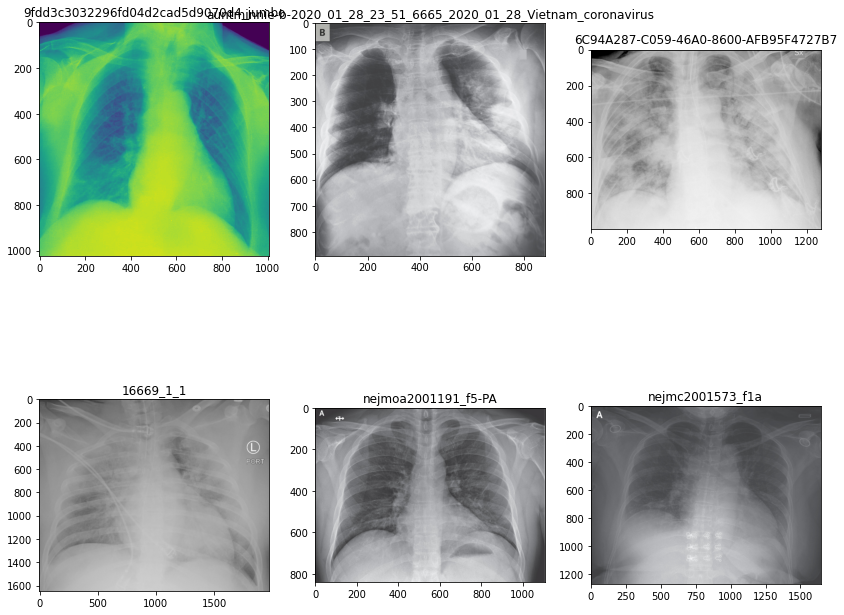

In [13]:
#plot_images(type="pneumonia", num=6)
#auxilia ao plotar imagens
counter = 0
num = 6
#print(type(train_dir))

fig = plt.figure(figsize=(14,12))
#print("antes do for")
#print("list_dir train_dir = {}".format(os.listdir(train_dir)))
#print("train_dir + file = {}".format(os.listdir(train_dir + file)))

for file in os.listdir('dataset/train/covid/'):
  #print('dataset/train/covid/' + file)
  if file.endswith(".jpeg"):
    #print("passou no if 1")
    if counter == num:
      #print("parrou no if 2 - nao achou nada")
      break

    img = mpimg.imread('dataset/train/covid/' + file)
    plt.subplot(231+counter)
    plt.title(file.split('.')[0])
    imgplot = plt.imshow(img)

    counter += 1
    #print("chegou até o final do for")

Plotando imagens normais

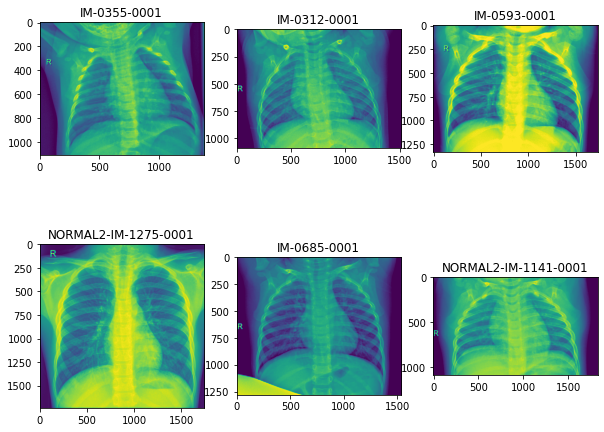

In [14]:
#plot_images(type="pneumonia", num=6)
#auxilia ao plotar imagens
counter = 0
num = 6
#print(type(train_dir))

fig = plt.figure(figsize=(10,8))
#print("antes do for")
#print("list_dir train_dir = {}".format(os.listdir(train_dir)))
#print("train_dir + file = {}".format(os.listdir(train_dir + file)))

for file in os.listdir('dataset/train/normal/'):
  #print('dataset/train/covid/' + file)
  if file.endswith(".jpeg"):
    #print("passou no if 1")
    if counter == num:
      #print("parrou no if 2 - nao achou nada")
      break

    img = mpimg.imread('dataset/train/normal/' + file)
    plt.subplot(231+counter)
    plt.title(file.split('.')[0])
    imgplot = plt.imshow(img)

    counter += 1
    #print("chegou até o final do for")

**MODELO**
pre trerinado usando a rede inceptionV3

In [0]:
import numpy as np

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.python.keras.preprocessing import image

In [0]:
pre_model = ResNet50(weights="imagenet") #carrega o modelo com os pesos da imagenet

------

Testando a classificalção com um imagem qualquer para ver o que a rede retorna antes de ser treinada com os nossos dados

In [48]:
img = image.load_img("/content/dataset/train/covid/16654_4_1.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = pre_model.predict(x)

for index, res in enumerate(decode_predictions(y)[0]):
  print('{}. {}: {:.3f}%'.format(index + 1, res[1], 100* res[2]))

1. groom: 23.905%
2. mosquito_net: 15.677%
3. feather_boa: 13.858%
4. fountain: 8.462%
5. gown: 5.533%


In [0]:
#img = mpimg.imread("example_2.jpg")
#imgplot = plt.imshow(img)

preparação dos dados

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
batch_size = 163

#criando gerador para dados de treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1) #cria um gerador de imagem no abstract

In [52]:
train_generator = train_datagen.flow_from_directory(
    train_dir, #diretorio com os dados de treino
    target_size=(150,150), #tamanho da imagem que queremos
    batch_size=batch_size, #quantos arquivos para ler de cada vez
    class_mode="categorical"
)

Found 252 images belonging to 3 classes.


In [53]:
#gerando dados para validação

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=1,
    class_mode="categorical",
)

Found 64 images belonging to 3 classes.


In [54]:
#gerando dados para teste

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

Found 80 images belonging to 3 classes.


#MODELO PARA TREINO EXCLUINDO A PRIMEIRA CAMADA

In [0]:
import keras

In [56]:
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(3, activation='softmax')(x)

for layer in base_model.layers:
  layer.trainable = False #congela os layers para nao treinar

final_model = keras.models.Model(inputs=base_model.inputs, outputs=predictions) #modelo final

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
final_model.compile(loss="categorical_crossentropy", # log loss
                    optimizer="sgd", # sgd ou adam - antes era adam - testar outros sgd, (optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
                    metrics=["accuracy"])

In [58]:
final_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

In [59]:
fit_history = final_model.fit_generator(
    train_generator, #generator dados treino
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator, #dados gerados para validação
    validation_steps=len(val_generator),
    verbose = 1
)

Epoch 1/50
2/2 [==============================] - 12s 6s/step - loss: 1.2423 - accuracy: 0.4722 - val_loss: 0.8802 - val_accuracy: 0.3594
Epoch 2/50
2/2 [==============================] - 6s 3s/step - loss: 0.8049 - accuracy: 0.6190 - val_loss: 0.8989 - val_accuracy: 0.3594
Epoch 3/50
2/2 [==============================] - 7s 4s/step - loss: 0.5634 - accuracy: 0.7579 - val_loss: 1.0714 - val_accuracy: 0.3594
Epoch 4/50
2/2 [==============================] - 8s 4s/step - loss: 0.5166 - accuracy: 0.8135 - val_loss: 0.9865 - val_accuracy: 0.3594
Epoch 5/50
2/2 [==============================] - 8s 4s/step - loss: 0.4857 - accuracy: 0.7937 - val_loss: 1.0022 - val_accuracy: 0.2969
Epoch 6/50
2/2 [==============================] - 8s 4s/step - loss: 0.4243 - accuracy: 0.8413 - val_loss: 0.9985 - val_accuracy: 0.2969
Epoch 7/50
2/2 [==============================] - 8s 4s/step - loss: 0.3294 - accuracy: 0.8889 - val_loss: 0.9702 - val_accuracy: 0.3125
Epoch 8/50
2/2 [========================

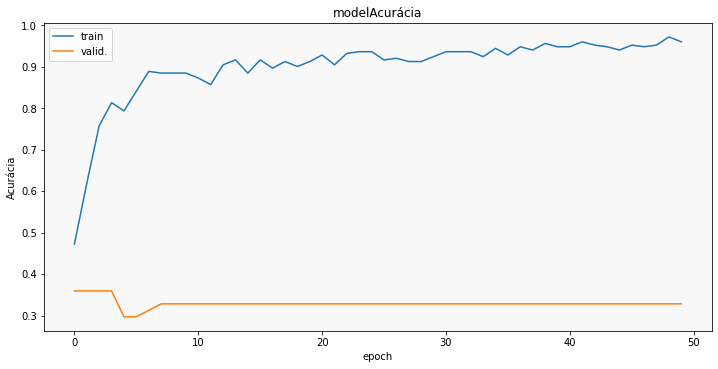

In [60]:
#display_training_curves(fit_history.history['acc'], fit_history.history['val_acc'], 'accuracy', 211)
#display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'loss', 212)

#def display_training_curves(training, validation, title, subplot):

training = fit_history.history['accuracy']
validation = fit_history.history['val_accuracy']
title = 'Acurácia'
subplot = 211

plt.subplots(figsize=(10,10))
plt.tight_layout()
ax = plt.subplot(subplot)
ax.set_facecolor('#F8F8F8')
ax.plot(training)
ax.plot(validation)
ax.set_title('model' + title)
ax.set_ylabel(title)
ax.set_xlabel('epoch')
ax.legend(['train', 'valid.'])

In [61]:
result = final_model.evaluate_generator(test_generator, steps=len(test_generator))
print('Loss: ', result[0])
print('Accuracy: ', result[1])

Loss:  1.219095230102539
Accuracy:  0.32499998807907104


In [62]:
train_generator.class_indices

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [63]:
#gerando todos os preditores
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = final_model.predict_generator(test_generator, steps = nb_samples).argmax(axis=-1)

predict

array([0, 0, 0, 0, ..., 0, 0, 0, 0])

In [64]:
#gerandor de rotulos verdadeiros
test_generator.classes

array([0, 0, 0, 0, ..., 2, 2, 2, 2], dtype=int32)

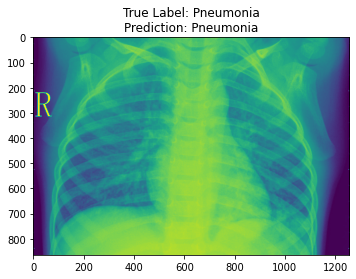

In [65]:
#@title Enter Filepath Here:
filename = "/content/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg" #@param {type:"string"}

img = image.load_img(filename, target_size=(150, 150))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)